# 비상장 중소기업의 상장 후 주가 예측 프로젝트

이 프로젝트는 비상장 중소기업의 상장 후 주가 예측 프로젝트이다. 과거 중소기업의 데이터와 상장 후 주가의 산술평균 데이터를 이용할 것이다. 중소기업의 데이터는 기업 내 재무재표와 거시정보를 이용한다.

기본설정

In [706]:
import numpy as np 
import os  
import matplotlib ##그림용
import matplotlib.pyplot as plt ##그림용
import sklearn ##사이킷런
import pandas as pd

np.random.seed(42) ##랜덤시드 

matplotlib.rc('font', family='NanumBarunGothic') ##matplotlib 한글을 위해
plt.rcParams['axes.unicode_minus'] = False ##한글을 위해

In [707]:
DATA = pd.read_csv('datasets//DB//DB_data.csv', engine='python')

# 기업규모명

우리가 예측하고 싶은 대상은 중소기업이므로 중소기업만 관찰한다.

In [708]:
data = DATA[DATA["기업규모명"] == '중소기업']
data["산술평균"].describe()

count    4.545400e+04
mean     2.766833e+04
std      1.039126e+05
min      9.400000e+01
25%      2.905250e+03
50%      6.297000e+03
75%      1.675775e+04
max      3.039182e+06
Name: 산술평균, dtype: float64

우리의 타겟값인 산술평균의 경우 평균은 8000이지만 최댓값은 604000이다. 주어진 데이터에 이상치가 많다고 판단되어 산술평균이 15000 이내의 데이터만 사용하도록 한다.

In [775]:
data = data[data["산술평균"] > 100000]
data["산술평균"].describe()

count    2.246000e+03
mean     3.175805e+05
std      3.528391e+05
min      1.000620e+05
25%      1.322050e+05
50%      1.860360e+05
75%      3.131668e+05
max      3.039182e+06
Name: 산술평균, dtype: float64

In [709]:
data = data[-(data["산술평균"].isnull())]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45454 entries, 0 to 47878
Data columns (total 41 columns):
회사명                  45454 non-null object
회계년도                 45454 non-null object
산업명                  45454 non-null object
소속코드                 45454 non-null float64
설립일                  45454 non-null object
종업원                  45454 non-null float64
당좌자산(*)              44838 non-null float64
재고자산(*)              44838 non-null float64
비유동자산(*)             44838 non-null float64
유동부채(*)              44838 non-null float64
비유동부채(*)             44838 non-null float64
자본금(*)               44838 non-null float64
자본잉여금(*)             44838 non-null float64
자본조정(*)              44838 non-null float64
기타포괄손익누계액(*)         44838 non-null float64
이익잉여금(*)             44838 non-null float64
매출액(영업수익)(*)         44838 non-null float64
매출원가(*)              44838 non-null float64
매출총이익(손실)            44838 non-null float64
판매비와관리비(영업비용)(*)     44838 non-null float64
영업이익(손실)       

In [710]:
data["산술평균"].describe()

count    4.545400e+04
mean     2.766833e+04
std      1.039126e+05
min      9.400000e+01
25%      2.905250e+03
50%      6.297000e+03
75%      1.675775e+04
max      3.039182e+06
Name: 산술평균, dtype: float64

평균은 8766에서 8169로 줄어들었지만, 최댓값은 149179다.

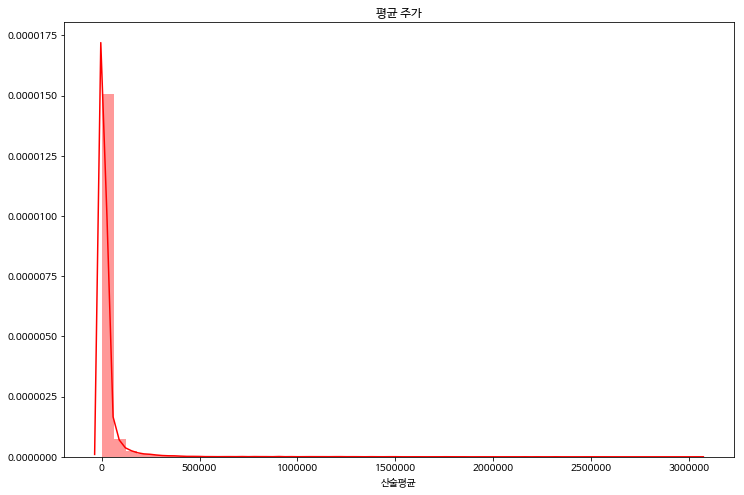

In [711]:
import seaborn as sns

plt.figure(figsize=(12,8))
sns.distplot(data["산술평균"], color='red')
plt.title('평균 주가')
plt.show()

주어진 데이터의 오른쪽 꼬리가 길게 뻗어있다.

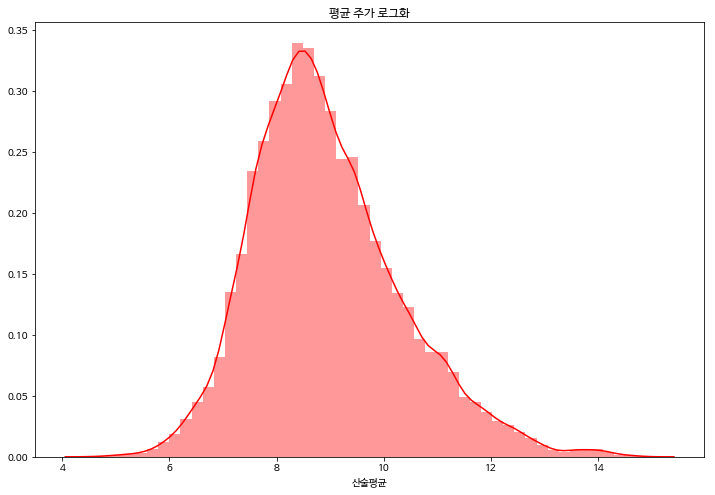

In [712]:
plt.figure(figsize=(12,8))
sns.distplot(np.log(data["산술평균"]+ 0.1), color='red')
plt.title('평균 주가 로그화')
plt.show()

주어진 타겟값을 log화하니, 정규분포의 모습과 상당히 비슷해졌다. 나중에 타겟값을 나중에 log화 해야한다.

# 데이터 구조 훑어보기

우리의 데이터를 간략하게 살펴보자.

In [713]:
data.head()

,회사명,회계년도,산업명,소속코드,설립일,종업원,당좌자산(*),재고자산(*),비유동자산(*),유동부채(*),...,현금의 증가(감소)(*),기업규모명,산술평균,경제성장률,총저축률,제조업 평균가동률,실업률,코스피지수,경상수지,발행주식수
0,(주)CMG제약,2011-03-01,의료용 물질 및 의약품 제조업,5.0,2001-08-01,213.0,9917659.0,3104211.0,15477735.0,4969819.0,...,-265171.0,중소기업,873.0,1.0,34.1,81.3,4.2,1939.30,-4253.0,108887244.0
1,(주)CMG제약,2011-06-01,의료용 물질 및 의약품 제조업,5.0,2001-08-01,213.0,11341653.0,3071427.0,14731279.0,5976935.0,...,-1160724.0,중소기업,577.0,0.6,34.1,80.6,3.4,2142.47,-2470.6,108887244.0
2,(주)CMG제약,2011-09-01,의료용 물질 및 의약품 제조업,5.0,2001-08-01,213.0,11407699.0,3352328.0,14717723.0,6389723.0,...,-1961689.0,중소기업,993.0,0.7,34.8,80.9,3.1,1880.11,11405.6,108887244.0
3,(주)CMG제약,2011-12-01,의료용 물질 및 의약품 제조업,5.0,2001-08-01,213.0,12521782.0,2743103.0,12283654.0,7620349.0,...,-1294857.0,중소기업,775.0,0.6,35.2,79.3,2.9,1847.51,11956.2,108887244.0
4,(주)CMG제약,2012-03-01,의료용 물질 및 의약품 제조업,5.0,2001-08-01,213.0,13370740.0,3654331.0,12100895.0,8146944.0,...,435947.0,중소기업,892.0,0.5,34.3,79.7,3.8,2045.08,-1292.0,108887244.0


In [714]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45454 entries, 0 to 47878
Data columns (total 41 columns):
회사명                  45454 non-null object
회계년도                 45454 non-null object
산업명                  45454 non-null object
소속코드                 45454 non-null float64
설립일                  45454 non-null object
종업원                  45454 non-null float64
당좌자산(*)              44838 non-null float64
재고자산(*)              44838 non-null float64
비유동자산(*)             44838 non-null float64
유동부채(*)              44838 non-null float64
비유동부채(*)             44838 non-null float64
자본금(*)               44838 non-null float64
자본잉여금(*)             44838 non-null float64
자본조정(*)              44838 non-null float64
기타포괄손익누계액(*)         44838 non-null float64
이익잉여금(*)             44838 non-null float64
매출액(영업수익)(*)         44838 non-null float64
매출원가(*)              44838 non-null float64
매출총이익(손실)            44838 non-null float64
판매비와관리비(영업비용)(*)     44838 non-null float64
영업이익(손실)       

1. 데이터에는 결측치가 몇 개 보인다.
2. 데이터 타입이 object인 데이터는, 회사명, 회계년도, 산업명, 설립일이 있다.
    - 회사명의 경우 각 데이터의 identity column이므로 나중에 삭제한다.
    - 회계년도의 경우 나중에 분기(03, 06, 09, 12)만 얻어서 명목형 변수로 변환한다.
    - 설립일의 경우년도만 얻어서 수치형 자료로 사용하겠다.
3. 소속코드의 경우 산술 평균과 연관있는 데이터이므로 나중에 삭제해야한다.

# 파일 정제

결측치가 몇 개 보인다. 산술평균의 경우 우리의 타겟값이므로 산술평균에 결측치가 있는 경우 객체를 버린다.

In [715]:
data = data[-(data["산술평균"].isnull())]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45454 entries, 0 to 47878
Data columns (total 41 columns):
회사명                  45454 non-null object
회계년도                 45454 non-null object
산업명                  45454 non-null object
소속코드                 45454 non-null float64
설립일                  45454 non-null object
종업원                  45454 non-null float64
당좌자산(*)              44838 non-null float64
재고자산(*)              44838 non-null float64
비유동자산(*)             44838 non-null float64
유동부채(*)              44838 non-null float64
비유동부채(*)             44838 non-null float64
자본금(*)               44838 non-null float64
자본잉여금(*)             44838 non-null float64
자본조정(*)              44838 non-null float64
기타포괄손익누계액(*)         44838 non-null float64
이익잉여금(*)             44838 non-null float64
매출액(영업수익)(*)         44838 non-null float64
매출원가(*)              44838 non-null float64
매출총이익(손실)            44838 non-null float64
판매비와관리비(영업비용)(*)     44838 non-null float64
영업이익(손실)       

데이터의 특성중 당좌좌산(\*)부터 현금의 증가(감소)(\*)의 경우 결측치의 개수가 일정한 것으로보아, 이 중 한 특성에서 결측치가 발생한 경우, 다른 특성에도 결측치가 발생한 것으로 추론할 수 있다.

In [716]:
data = data[-data["당좌자산(*)"].isnull()]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44838 entries, 0 to 47878
Data columns (total 41 columns):
회사명                  44838 non-null object
회계년도                 44838 non-null object
산업명                  44838 non-null object
소속코드                 44838 non-null float64
설립일                  44838 non-null object
종업원                  44838 non-null float64
당좌자산(*)              44838 non-null float64
재고자산(*)              44838 non-null float64
비유동자산(*)             44838 non-null float64
유동부채(*)              44838 non-null float64
비유동부채(*)             44838 non-null float64
자본금(*)               44838 non-null float64
자본잉여금(*)             44838 non-null float64
자본조정(*)              44838 non-null float64
기타포괄손익누계액(*)         44838 non-null float64
이익잉여금(*)             44838 non-null float64
매출액(영업수익)(*)         44838 non-null float64
매출원가(*)              44838 non-null float64
매출총이익(손실)            44838 non-null float64
판매비와관리비(영업비용)(*)     44838 non-null float64
영업이익(손실)       

이 중 발행주식수에 결측치가 있는 샘플이 있는데 샘플의 개수가 적어서 객체를 버리는 것이 좋을 것 같다.

In [717]:
data = data[-data["발행주식수"].isnull()]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44808 entries, 0 to 47878
Data columns (total 41 columns):
회사명                  44808 non-null object
회계년도                 44808 non-null object
산업명                  44808 non-null object
소속코드                 44808 non-null float64
설립일                  44808 non-null object
종업원                  44808 non-null float64
당좌자산(*)              44808 non-null float64
재고자산(*)              44808 non-null float64
비유동자산(*)             44808 non-null float64
유동부채(*)              44808 non-null float64
비유동부채(*)             44808 non-null float64
자본금(*)               44808 non-null float64
자본잉여금(*)             44808 non-null float64
자본조정(*)              44808 non-null float64
기타포괄손익누계액(*)         44808 non-null float64
이익잉여금(*)             44808 non-null float64
매출액(영업수익)(*)         44808 non-null float64
매출원가(*)              44808 non-null float64
매출총이익(손실)            44808 non-null float64
판매비와관리비(영업비용)(*)     44808 non-null float64
영업이익(손실)       

이제 우리의 데이터에 결측치가 있는 샘플이 없어졌다.

# 데이터 구조

## 명목형 변수

### 산업명

각 산업명의 경우에 얼마나 샘플이 속해있는지 살펴보자.

In [718]:
data["산업명"].value_counts()

  전자부품, 컴퓨터, 영상, 음향 및 통신장비 제조업    6617
  기타 기계 및 장비 제조업                  3570
  화학물질 및 화학제품 제조업; 의약품 제외         2939
  의료용 물질 및 의약품 제조업                2484
  도매 및 상품 중개업                     2473
  자동차 및 트레일러 제조업                  2296
  출판업                             2123
  전문 서비스업                         2043
  1차 금속 제조업                       1972
  전기장비 제조업                        1389
  식료품 제조업                         1218
  고무 및 플라스틱제품 제조업                 1127
  의료, 정밀, 광학기기 및 시계 제조업           1127
  금속가공제품 제조업; 기계 및 가구 제외          1082
  종합 건설업                          1025
  비금속 광물제품 제조업                     883
  컴퓨터 프로그래밍, 시스템 통합 및 관리업          794
  펄프, 종이 및 종이제품 제조업                740
  소매업; 자동차 제외                      725
  정보서비스업                           635
  의복, 의복 액세서리 및 모피제품 제조업           629
  기타 운송장비 제조업                      540
  영상ㆍ오디오 기록물 제작 및 배급업              538
  사업지원 서비스업                        441
  섬유제품 제조업; 의복제외                   431
  건축기술, 엔지니어링 및 기타 과학기술 서

이 데이터를 시각화 해보자.

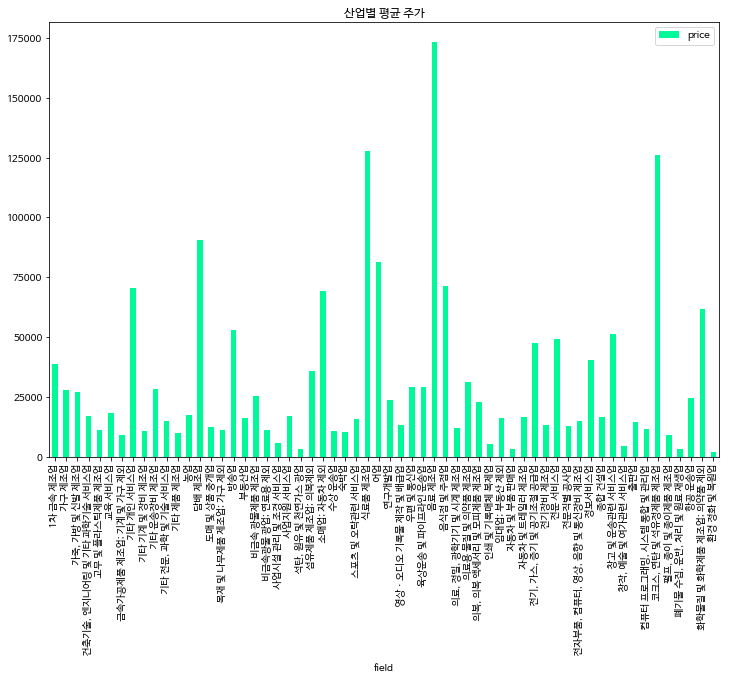

In [719]:
tmp = data[["산업명","산술평균"]].copy()
tmp.columns = ["field", "price"]

tmp.groupby(['field']).mean().plot.bar(figsize=(12,8), color='mediumspringgreen')
plt.title('산업별 평균 주가')
plt.show()

### 특징 설명하기

## 수치형 데이터

### 설립일

설립일에 따른 산술 평균

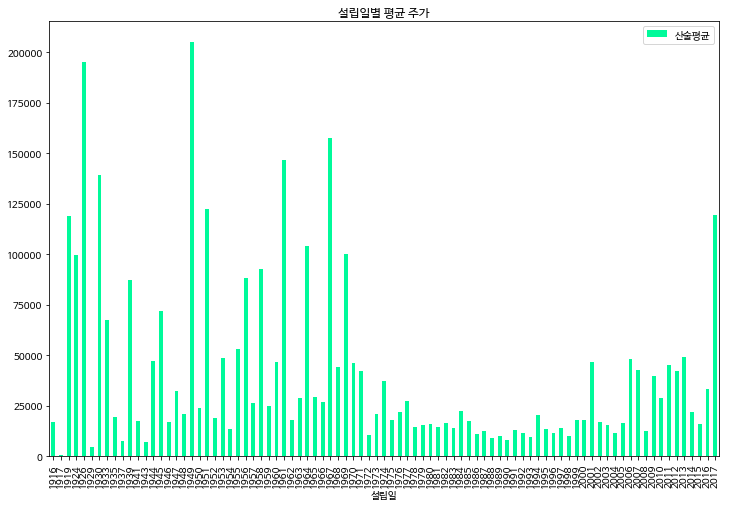

In [720]:
data_est_stock = data[["설립일", '산술평균']].copy()
data_est_stock["설립일"] = data_est_stock["설립일"].str.split('-', n=2, expand=True)[0]

data_est_stock.groupby("설립일").mean().plot.bar(figsize=(12,8), color='mediumspringgreen')
plt.title('설립일별 평균 주가')
plt.show()

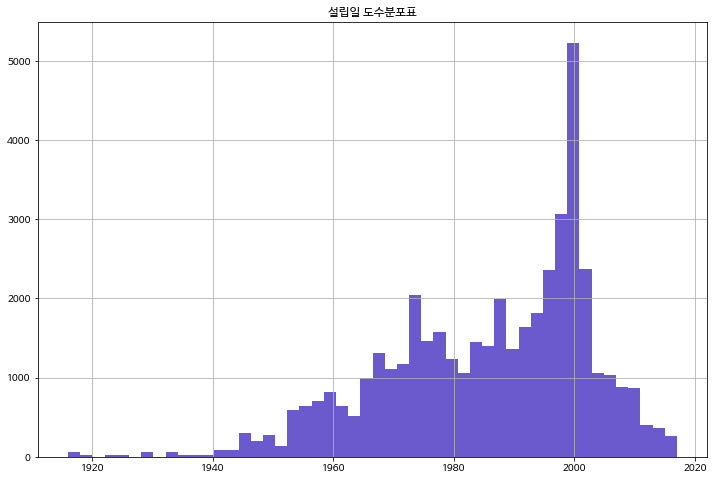

In [721]:
data_est_stock["설립일"].astype('float').hist(bins=50, figsize=(12,8), color='slateblue')
plt.title('설립일 도수분포표')
plt.show()

왼쪽 꼬리에 있는 데이터의 산술평균의 값이 크다.

### 다른 수치형 데이터

In [722]:
data.iloc[:, :20].describe()

,소속코드,종업원,당좌자산(*),재고자산(*),비유동자산(*),유동부채(*),비유동부채(*),자본금(*),자본잉여금(*),자본조정(*),기타포괄손익누계액(*),이익잉여금(*),매출액(영업수익)(*),매출원가(*),매출총이익(손실),판매비와관리비(영업비용)(*)
count,44808.000000,44808.000000,4.480800e+04,4.480800e+04,4.480800e+04,4.480800e+04,4.480800e+04,4.480800e+04,4.480800e+04,4.480800e+04,4.480800e+04,4.480800e+04,4.480800e+04,4.480800e+04,4.480800e+04,4.480800e+04
mean,3.409503,856.737391,2.611041e+08,5.990340e+07,6.354019e+08,2.547639e+08,1.691825e+08,4.595837e+07,1.064379e+08,-1.512461e+07,1.273028e+07,3.824739e+08,4.760478e+08,3.753848e+08,1.006631e+08,7.097468e+07
std,1.981362,3978.854465,1.602775e+09,2.885296e+08,4.104474e+09,1.242300e+09,1.265648e+09,1.972258e+08,4.160067e+08,3.922651e+08,1.235203e+08,3.634313e+09,3.173518e+09,2.459679e+09,9.006740e+08,5.997196e+08
min,1.000000,2.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-8.267000e+03,0.000000e+00,-2.552957e+09,-1.168197e+10,-1.484043e+09,-4.329456e+09,0.000000e+00,0.000000e+00,-4.123609e+09,-3.188634e+06
25%,1.000000,100.000000,2.212634e+07,2.226129e+06,3.189294e+07,1.283784e+07,2.376688e+06,5.475000e+06,1.053639e+07,-4.383834e+06,0.000000e+00,1.040592e+07,2.045689e+07,1.253418e+07,3.843675e+06,3.243011e+06
50%,5.000000,211.000000,4.516625e+07,9.646722e+06,6.684714e+07,3.616978e+07,8.948252e+06,9.852021e+06,2.421164e+07,-8.137300e+05,0.000000e+00,3.845713e+07,5.486654e+07,3.900852e+07,1.055281e+07,7.485700e+06
75%,5.000000,453.000000,1.056791e+08,2.969662e+07,1.869590e+08,1.020843e+08,3.064321e+07,2.214416e+07,5.509354e+07,0.000000e+00,7.898818e+05,1.088283e+08,1.628895e+08,1.245439e+08,3.011197e+07,2.003993e+07
max,6.000000,103023.000000,6.543064e+10,7.837144e+09,1.280860e+11,4.449508e+10,4.218336e+10,3.657652e+09,1.003965e+10,1.329510e+10,8.581563e+09,1.509290e+11,1.619150e+11,1.107320e+11,6.051535e+10,2.583356e+10


In [723]:
data.iloc[:, 20:].describe()

,영업이익(손실),영업외수익(*),영업외비용(*),법인세비용차감전(계속사업)손익,(계속사업손익)법인세비용,계속사업이익(손실),당기순이익(순손실),영업활동으로 인한 현금흐름(*),투자활동으로 인한 현금흐름(*),재무활동으로 인한 현금흐름(*),환율변동으로 인한 차이조정,현금의 증가(감소)(*),산술평균,경제성장률,총저축률,제조업 평균가동률,실업률,코스피지수,경상수지,발행주식수
count,4.480800e+04,4.480800e+04,4.480800e+04,4.480800e+04,4.480800e+04,4.480800e+04,4.480800e+04,4.480800e+04,4.480800e+04,4.480800e+04,4.480800e+04,4.480800e+04,4.480800e+04,44808.000000,44808.000000,44808.000000,44808.000000,44808.000000,44808.000000,4.480800e+04
mean,2.968838e+07,2.504034e+07,2.383518e+07,3.089354e+07,6.721418e+06,2.417202e+07,2.562470e+07,3.992536e+07,-3.701241e+07,-8.630578e+05,-2.349838e+04,1.844157e+06,2.802684e+04,0.702551,35.142693,75.728232,3.458516,2036.053069,18392.150768,4.236067e+07
std,3.735805e+08,1.906462e+08,1.512029e+08,4.215106e+08,8.608674e+07,3.390456e+08,3.440693e+08,4.902063e+08,3.916451e+08,1.901429e+08,3.332839e+06,7.543943e+07,1.046151e+05,0.313017,0.944520,2.787587,0.438387,153.125284,8647.826096,1.930909e+08
min,-4.695036e+09,-5.388529e+06,-5.367481e+06,-5.818763e+09,-1.450958e+09,-4.367805e+09,-4.367805e+09,-2.678869e+09,-2.811881e+10,-1.180199e+10,-1.293088e+08,-1.867711e+09,9.400000e+01,-0.200000,33.700000,71.800000,2.800000,1843.470000,-4253.000000,4.075920e+05
25%,1.466165e+05,5.633152e+05,5.701110e+05,-1.268718e+05,0.000000e+00,-1.509590e+05,-1.441155e+05,-1.126466e+06,-1.162654e+07,-3.120000e+06,-4.498250e+03,-2.662433e+06,2.988000e+03,0.600000,34.300000,73.400000,3.100000,1939.300000,12833.000000,1.142672e+07
50%,2.521986e+06,1.650021e+06,1.820646e+06,2.486277e+06,3.875690e+05,2.064600e+06,2.076532e+06,2.350960e+06,-3.000000e+06,0.000000e+00,0.000000e+00,5.587500e+03,6.423000e+03,0.700000,34.900000,75.500000,3.400000,1991.970000,21472.900000,2.085682e+07
75%,9.392068e+06,5.406402e+06,5.822912e+06,9.778532e+06,1.944774e+06,7.940403e+06,8.013559e+06,1.048880e+07,-1.420948e+05,4.908356e+06,1.610000e+02,3.068445e+06,1.704025e+04,0.900000,36.000000,77.300000,3.800000,2068.540000,25944.500000,4.000000e+07
max,3.485709e+10,1.022012e+10,6.911713e+09,3.653355e+10,7.732715e+09,2.880084e+10,2.880084e+10,3.890619e+10,2.676584e+09,6.113317e+09,5.030681e+08,4.011573e+09,3.039182e+06,1.400000,37.000000,81.300000,4.300000,2476.370000,28086.900000,7.322954e+09


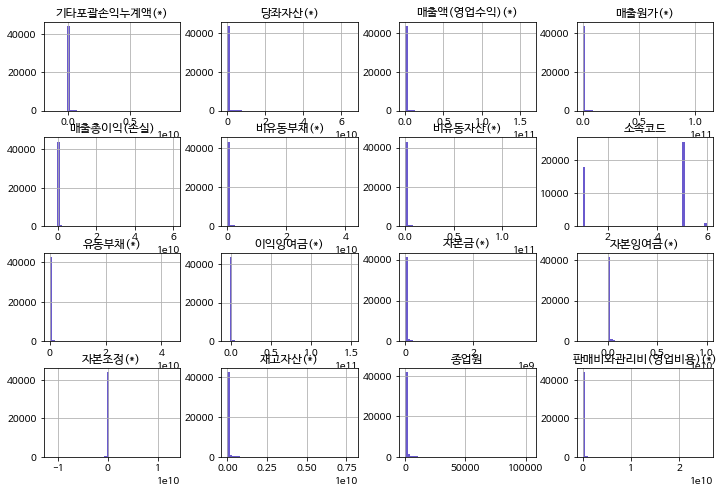

In [724]:
data.iloc[:,:20].hist(bins=50, figsize=(12,8), color='slateblue')
plt.show()

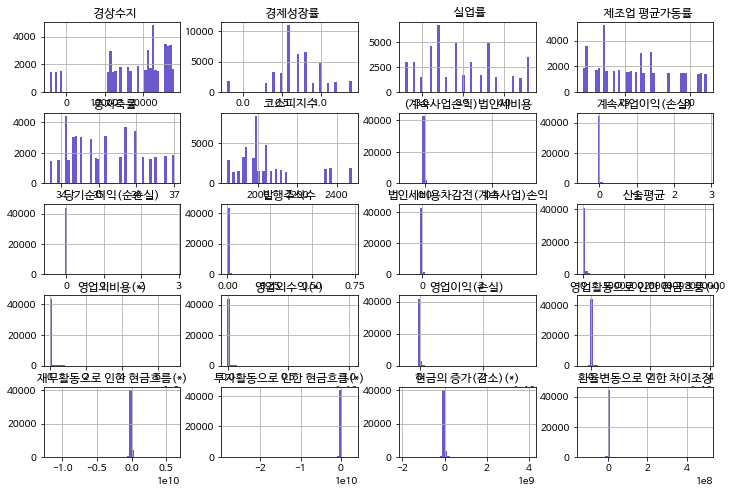

In [725]:
data.iloc[:,20:].hist(bins=50, figsize=(12,8),color='slateblue')
plt.show()

왼쪽에 데이터가 몰려있는 경우가 많으니 몇 특성들을 골라서 log변환을 해야한다.
- 특성들
    - 당좌자산(\*), 매출액(영업수익)(\*), 매출원가(\*), 매출총이익(손실), 비유동부채(\*), 비유동자산(\*)
    - 유동부채(\*) 자본금(\*) 자본잉여금(\*) 재고자산(\*) 종업원 판매비와관리비(영업비용)(\*)
    - 발행주식수 영업외비용(\*) 재무활동으로 인한 현금흐름(\*)

# 상관관계 조사

In [726]:
corr_matrix = data.corr()
corr_matrix["산술평균"].sort_values(ascending=False)

산술평균                 1.000000
이익잉여금(*)             0.396240
당좌자산(*)              0.364451
영업이익(손실)             0.355714
종업원                  0.351358
매출총이익(손실)            0.351300
법인세비용차감전(계속사업)손익     0.343791
당기순이익(순손실)           0.341330
계속사업이익(손실)           0.341233
(계속사업손익)법인세비용        0.339405
매출액(영업수익)(*)         0.335271
재고자산(*)              0.332106
영업활동으로 인한 현금흐름(*)    0.326965
비유동자산(*)             0.325296
유동부채(*)              0.311331
발행주식수                0.310722
판매비와관리비(영업비용)(*)     0.306008
매출원가(*)              0.303935
영업외수익(*)             0.247885
자본잉여금(*)             0.239567
영업외비용(*)             0.233027
기타포괄손익누계액(*)         0.205806
비유동부채(*)             0.099602
현금의 증가(감소)(*)        0.087819
자본금(*)               0.075501
  경상수지               0.017314
  총저축률               0.011498
  실업률                0.009394
 코스피지수               0.006466
환율변동으로 인한 차이조정       0.004291
  경제성장률             -0.000736
  제조업 평균가동률         -0.017009
재무활동으로 인한 현금흐름(*)   -0.192920
자본조정(*)   

상관 관계가 높은 특성들은 "산술평균", "영업이익(손실)", "당좌자산(\*)", "법인세비용차감전(계속사업)손익", "자본금(\*)", "산술평균", "당기순이익(순손실)", "계속사업이익(손실)", "매출총이익(손실)"이다.

이를 산점도로 그려보자

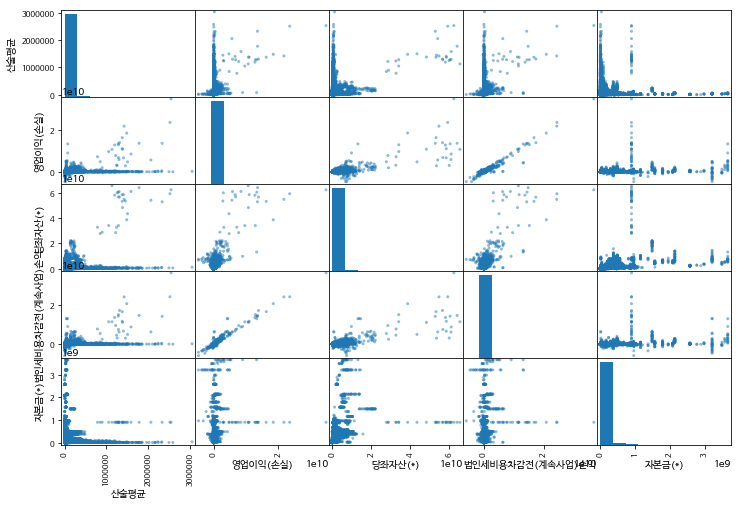

In [727]:
from pandas.plotting import scatter_matrix

attributes1 = ["산술평균","영업이익(손실)", "당좌자산(*)", "법인세비용차감전(계속사업)손익", "자본금(*)"]
scatter_matrix(data[attributes1], figsize=(12, 8))
plt.show()

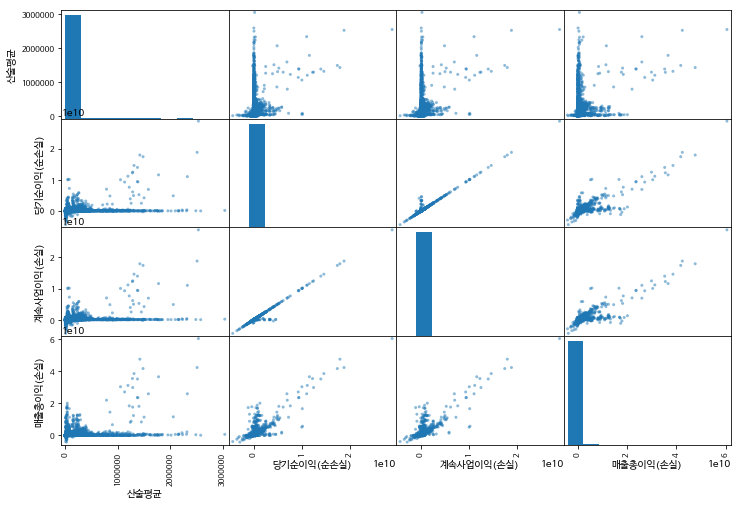

In [728]:
attributes2 = ["산술평균","당기순이익(순손실)", "계속사업이익(손실)", "매출총이익(손실)"]
scatter_matrix(data[attributes2], figsize=(12, 8))
plt.show()

상관 관계를 조사해본 결과, 각 특성들끼리 상관도가 굉장히 높다. 이런 경우를 해결하기 위해 PCA 전처리를 추가해야한다.

#### 수치형 데이터 log화와 PCA

log화가 필요한 데이터들
    - 당좌자산(\*), 매출액(영업수익)(\*), 매출원가(\*), 매출총이익(손실), 비유동부채(\*), 비유동자산(\*)
    - 유동부채(\*), 자본금(\*), 자본잉여금(\*), 재고자산(\*), 종업원 판매비와관리비(영업비용)(\*)
    - 발행주식수 영업외비용(\*), 재무활동으로 인한 현금흐름(\*)  
PCA를 할 데이터들
    - 당좌자산(\*)~현금의 증가(감소)(\*)
    -   경제성장률 ~ 경상수지

#### log화

In [729]:
log_data = ["당좌자산(*)", "매출액(영업수익)(*)", "매출원가(*)", "매출총이익(손실)", "비유동부채(*)", "비유동자산(*)", "유동부채(*)" ,
     "자본금(*)", "자본잉여금(*)", "재고자산(*)", "종업원", "판매비와관리비(영업비용)(*)",
    "발행주식수", "영업외비용(*)", "재무활동으로 인한 현금흐름(*)"  ]
data_log = data[log_data].copy()
for i in log_data:
    data_log.loc[:, i] = data_log[i] - data_log[i].min() + 1
data_log = np.log(data_log)

In [730]:
data_final = data.drop(log_data, axis=1).join(data_log).copy()

#### PCA

In [731]:
micro_att = ['당좌자산(*)','재고자산(*)','비유동자산(*)','유동부채(*)','비유동부채(*)',
        '자본금(*)','자본잉여금(*)','자본조정(*)','기타포괄손익누계액(*)',
        '이익잉여금(*)','매출액(영업수익)(*)','매출원가(*)','매출총이익(손실)',
        '판매비와관리비(영업비용)(*)','영업이익(손실)','영업외수익(*)','영업외비용(*)',
        '법인세비용차감전(계속사업)손익','(계속사업손익)법인세비용','계속사업이익(손실)',
        '당기순이익(순손실)','영업활동으로 인한 현금흐름(*)',
        '투자활동으로 인한 현금흐름(*)','재무활동으로 인한 현금흐름(*)',
       '환율변동으로 인한 차이조정','현금의 증가(감소)(*)']

macro_att = ['  경제성장률','  총저축률','  제조업 평균가동률','  실업률',
            ' 코스피지수','  경상수지']

PCA_micro = data_final[micro_att].copy()
PCA_macro = data_final[macro_att].copy()

먼저 주어진 데이터를 95%이상 설명가능한 차원의 수를 각각 구하자.

In [732]:
from sklearn.decomposition import PCA

pca1 = PCA()
pca1.fit(PCA_micro)
cumsum = np.cumsum(pca1.explained_variance_ratio_) ## 모든 배열의 원소들을 누적으로 다 더한 놈들 반환
d1 = np.argmax(cumsum>=0.90)+1 ## argmax는 제일 큰 수의 index를 1차원 배열로 봤을 때의 index로 반환

pca1 = PCA(n_components=d1)

pca1.fit_transform(PCA_micro), d1

(array([[-4.34042782e+08],
        [-4.33210011e+08],
        [-4.33015805e+08],
        ...,
        [-3.20498114e+08],
        [-3.32918389e+08],
        [-3.72796808e+08]]), 1)

In [733]:
index_micro = PCA_micro.index
        
col = []
for i in range(d1):
    col.append('pca1_%s' %i)
        
XdD1 = pd.DataFrame(pca1.transform(PCA_micro), 
                    index=index_micro, columns = col)
XdD1.head()

,pca1_0
0,-4.340428e+08
1,-4.332100e+08
2,-4.330158e+08
3,-4.355545e+08
4,-4.351588e+08


In [734]:
pca2 = PCA()
pca2.fit(PCA_macro)
cumsum = np.cumsum(pca2.explained_variance_ratio_) ## 모든 배열의 원소들을 누적으로 다 더한 놈들 반환
d2 = np.argmax(cumsum>=0.95)+1 ## argmax는 제일 큰 수의 index를 1차원 배열로 봤을 때의 index로 반환

pca2 = PCA(n_components=d2)

pca2.fit_transform(PCA_macro), d2

(array([[22645.20994138],
        [20862.67725537],
        [ 6986.65230718],
        ...,
        [ 3936.9452325 ],
        [-7552.56219834],
        [ -458.93816693]]), 1)

In [735]:
index_macro = PCA_macro.index
        
col = []
for i in range(d2):
    col.append('pca2_%s' %i)
        
XdD2 = pd.DataFrame(pca2.transform(PCA_macro), 
                    index=index_macro, columns = col)
XdD2.head()

,pca2_0
0,22645.209941
1,20862.677255
2,6986.652307
3,6436.073393
4,19684.141062


#### 데이터 log화와 PCA

In [736]:
data_final = data.drop(log_data, axis=1).join(data_log).copy()

In [737]:
data_final.drop(PCA_micro, axis=1, inplace=True)
data_final.drop(PCA_macro, axis=1, inplace=True)

In [738]:
data_final = data_final.join(XdD1)
data_final = data_final.join(XdD2)

In [739]:
log = data_final["산술평균"] - data_final["산술평균"].min() + 0.01

In [740]:
log_labels = np.log(data_final["산술평균"].copy())
data_final["log_labels"] = log_labels

#### 실험 시각화

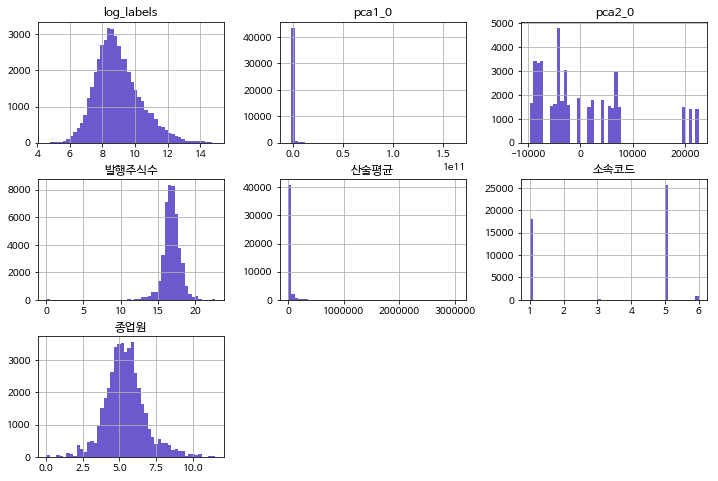

In [741]:
data_final.hist(bins=50, figsize=(12,8), color='slateblue')
plt.show()

In [742]:
corr_matrix = data_final.corr()
corr_matrix["log_labels"].sort_values(ascending=False)

log_labels    1.000000
산술평균          0.544147
종업원           0.402847
pca1_0        0.220909
pca2_0       -0.064862
소속코드         -0.309209
발행주식수        -0.327087
Name: log_labels, dtype: float64

In [743]:
attributes = ["log_labels","종업원", "pca1_1", "발행주식수", "pca1_0"]
scatter_matrix(data_final[attributes], figsize=(12, 8))
plt.show()

KeyError: "['pca1_1'] not in index"

#### 분기 추가

분기별 산술평균의 차이는 두드러지지 않지만, 1분기와 나머지 분기를 나눌 수 있을 것 같다.

In [744]:
data_final["분기"] = data_final["회계년도"].str.split("-", n=2, expand=True)[1]
data_quater = data_final[["분기", "산술평균"]]

,산술평균
분기,
03,28000.954290
06,28355.839578
09,28121.435348
12,27639.001926


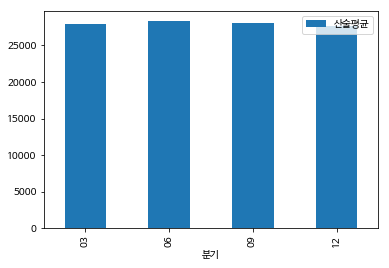

In [745]:
display(data_quater.groupby("분기").mean())
display(data_quater.groupby("분기").mean().plot.bar())

# 머신러닝 알고리즘에 학습시키기 위해 데이터를 전처리하자.

1. train set, test set 나누기
2. 특성값, 타겟값 log화
3. PCA
4. 설립일에서 연도만 추출하기
5. 회계년도에서 분기 추출하기(명목화)

In [746]:
data_final.head()

,회사명,회계년도,산업명,소속코드,설립일,기업규모명,산술평균,종업원,발행주식수,pca1_0,pca2_0,log_labels,분기
0,(주)CMG제약,2011-03-01,의료용 물질 및 의약품 제조업,5.0,2001-08-01,중소기업,873.0,5.356586,18.502073,-4.340428e+08,22645.209941,6.771936,03
1,(주)CMG제약,2011-06-01,의료용 물질 및 의약품 제조업,5.0,2001-08-01,중소기업,577.0,5.356586,18.502073,-4.332100e+08,20862.677255,6.357842,06
2,(주)CMG제약,2011-09-01,의료용 물질 및 의약품 제조업,5.0,2001-08-01,중소기업,993.0,5.356586,18.502073,-4.330158e+08,6986.652307,6.900731,09
3,(주)CMG제약,2011-12-01,의료용 물질 및 의약품 제조업,5.0,2001-08-01,중소기업,775.0,5.356586,18.502073,-4.355545e+08,6436.073393,6.652863,12
4,(주)CMG제약,2012-03-01,의료용 물질 및 의약품 제조업,5.0,2001-08-01,중소기업,892.0,5.356586,18.502073,-4.351588e+08,19684.141062,6.793466,03


In [747]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44808 entries, 0 to 47878
Data columns (total 13 columns):
회사명           44808 non-null object
회계년도          44808 non-null object
산업명           44808 non-null object
소속코드          44808 non-null float64
설립일           44808 non-null object
기업규모명         44808 non-null object
산술평균          44808 non-null float64
종업원           44808 non-null float64
발행주식수         44808 non-null float64
pca1_0        44808 non-null float64
pca2_0        44808 non-null float64
log_labels    44808 non-null float64
분기            44808 non-null object
dtypes: float64(7), object(6)
memory usage: 6.0+ MB


## 1. train 데이터와 test 데이터 나누기

In [748]:
from sklearn.model_selection import train_test_split

train,test = train_test_split(data, test_size=0.2, random_state=42)

labels = train["산술평균"]
log_labels = np.log(labels)
train.drop(["산술평균"], axis=1, inplace=True)

c:\python\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## 2. 특성값 log화

train set, test set 나누기
특성값, 타겟값 log화
설립일에서 연도만 추출하기
회계년도에서 분기 추출하기(명목화)

In [749]:
from sklearn.base import BaseEstimator, TransformerMixin

In [750]:
class numeric_log(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_log = X[log_data].copy()
        for i in log_data:
            X_log.loc[:, i] = X_log[i] - X_log[i].min() + 1
        X_log = X_log - X_log.min().min() + 1
        X_log = np.log(X_log)
        tmp = X.drop(log_data, axis=1)
        
        
        return tmp.join(X_log)

## 3. PCA

In [751]:
class numeric_PCA(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        PCA_micro = X[micro_att].copy()
        PCA_macro = X[macro_att].copy()
        
        ## micro
        pca1 = PCA()
        pca1.fit(PCA_micro)
        cumsum = np.cumsum(pca1.explained_variance_ratio_) ## 모든 배열의 원소들을 누적으로 다 더한 놈들 반환
        d1 = np.argmax(cumsum>=0.90)+1 ## argmax는 제일 큰 수의 index를 1차원 배열로 봤을 때의 index로 반환

        pca1 = PCA(n_components=d1)
        pca1.fit(PCA_micro)
        
        ## macro
        pca2 = PCA()
        pca2.fit(PCA_macro)
        cumsum = np.cumsum(pca2.explained_variance_ratio_) ## 모든 배열의 원소들을 누적으로 다 더한 놈들 반환
        d2 = np.argmax(cumsum>=0.95)+1 ## argmax는 제일 큰 수의 index를 1차원 배열로 봤을 때의 index로 반환

        pca2 = PCA(n_components=d2)
        pca1.fit(PCA_macro)
        
        return self
    
    def transform(self, X, y=None):
        ## micro
        self.PCA_micro = X[micro_att].copy()
        self.PCA_macro = X[macro_att].copy()
        
        self.index_micro = self.PCA_micro.index
        self.col = []
        for i in range(d1):
            self.col.append('pca1_%s' %i)
        
        XdD1 = pd.DataFrame(pca1.transform(self.PCA_micro), 
                                index=self.index_micro, columns = self.col)
        
        ## macro
        self.index_macro = self.PCA_macro.index
        
        self.col = []
        for i in range(d2):
            self.col.append('pca2_%s' %i)
        
        XdD2 = pd.DataFrame(pca2.transform(self.PCA_macro), 
                            index=self.index_macro, columns = self.col)
        
        X.drop(self.PCA_micro, axis=1, inplace=True)
        X.drop(self.PCA_macro, axis=1, inplace=True)        
    
        
        X = X.join(XdD1)
        X = X.join(XdD2)
        
        return X

## 4. 설립일에서 연도만 추출하기

In [752]:
class cat_date_of_establish(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X["설립일"] = X["설립일"].str.split('-', n = 1, expand=True)[0].astype("float")
        return X

## 5. 회계년도 분기 추출

In [753]:
class cat_add_quater(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X["분기"] = X["회계년도"].str.split("-", n=2, expand=True)[1]
        X.drop(["회계년도"], axis=1, inplace=True)
        return X

## 6. 회사명, 기업규모명, 소속코드 지우기

In [754]:
class cat_drop_some_attributes(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.drop(["회사명", "기업규모명", "소속코드"], axis=1)

## 파이프라인 구축

In [755]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

cat_attributes = ["회사명", "기업규모명", "소속코드", "산업명", '회계년도']
num_attributes = []
for i in train.columns:
    if i not in cat_attributes:
        num_attributes.append(i)

In [756]:
num_pipeline = Pipeline([
        ('log',numeric_log()),
        ('PCA',numeric_PCA()),
        ('data_of_establish', cat_date_of_establish()),
        ('StandardScaler',StandardScaler()),
    ])

In [757]:
cat_pipeline = Pipeline([

        ('add_quater', cat_add_quater()),
        ('drop_some_attributes',cat_drop_some_attributes()),
        ('onehotencoder',OneHotEncoder(categories='auto')),
    ])

In [758]:
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attributes),
        ("cat", cat_pipeline, cat_attributes),
    ])

In [759]:
train_prepared = full_pipeline.fit_transform(train)
train_prepared.shape

(35846, 69)

## 머신러닝 트레이닝

In [760]:
from sklearn.metrics import mean_squared_error

### LinearRegression

In [761]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(train_prepared, log_labels)

train_predictions = lin_reg.predict(train_prepared)
real_train_predictions = np.exp(train_predictions)
lin_mse = mean_squared_error(labels, real_train_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

840297.1949276915

### DecisionTreeRegressor

In [762]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(random_state=42, max_depth=40)
tree_reg.fit(train_prepared, log_labels)

train_predictions = tree_reg.predict(train_prepared)
real_train_predictions = np.exp(train_predictions)
tree_mse = mean_squared_error(labels, real_train_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

10.7298151836889

### RandomForestRegressor

from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=55, random_state=42, max_depth=40)
forest_reg.fit(train_prepared, log_labels)

train_predictions = forest_reg.predict(train_prepared)
real_train_predictions = np.exp(train_predictions)
forest_mse = mean_squared_error(labels, real_train_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

## cross_val_score

모델 선정

from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())

### Linear regression

scores = cross_val_score(lin_reg, train_prepared, log_labels,
scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

### DecisionTreeRegressor

scores = cross_val_score(tree_reg, train_prepared, labels,
scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

### RandomForestRegressor

scores = cross_val_score(forest_reg, train_prepared, labels,
scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

### 랜덤 그리드 탐색

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

param_dist = {'n_estimators': [55],
                "max_depth": [40],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["mse"]}

n_iter_search = 20
random_search = RandomizedSearchCV(forest_reg, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5)
random_search.fit(train_prepared, log_labels)

cvres = random_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(mean_score), params)

random_search.best_estimator_

### 랜덤 포레스트 마지막 

In [763]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=40,
           max_features=10, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=55, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)
forest_reg.fit(train_prepared, log_labels)

train_predictions = forest_reg.predict(train_prepared)
real_train_predictions = np.exp(train_predictions)
forest_mse = mean_squared_error(labels, real_train_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

219.7907980660371

### DesicionTree Regressor 마지막

In [764]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(max_depth=40,
           max_features=10, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           random_state=42)
tree_reg.fit(train_prepared, log_labels)

train_predictions = tree_reg.predict(train_prepared)
real_train_predictions = np.exp(train_predictions)
tree_mse = mean_squared_error(labels, real_train_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

996.2477863495631

# 테스트

In [765]:
test_labels = test["산술평균"]
log_test_labels = np.log(test_labels)
test.drop(["산술평균"], axis=1, inplace=True)

c:\python\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [766]:
test_prepared = full_pipeline.transform(test)
test_prepared.shape

(8962, 69)

In [767]:
test_predictions = forest_reg.predict(test_prepared)
real_test_predictions = np.exp(test_predictions)
forest_mse = mean_squared_error(test_labels, real_test_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

38908.93927076883

노리미트 ->  13691  
10만원 -> 6107  
75만원 -> 13691  
7만5천 -> 5260  
5만 -> 5003  
4만 -> 4138  
3만 -> 3305  

전체 데이터 38908

In [768]:
test_predictions = tree_reg.predict(test_prepared)
real_test_predictions = np.exp(test_predictions)
tree_mse = mean_squared_error(test_labels, real_test_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

51409.0577634006

# 제출

In [769]:
submission = pd.read_csv('datasets//DB//submission.csv', engine='python')
submission = submission[data.columns]

In [770]:
submission_labels = submission["산술평균"]
log_submission_labels = np.log(submission_labels)
submission.drop(["산술평균"], axis=1, inplace=True)

In [771]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 40 columns):
회사명                  24 non-null object
회계년도                 24 non-null object
산업명                  24 non-null object
소속코드                 24 non-null int64
설립일                  24 non-null object
종업원                  24 non-null float64
당좌자산(*)              24 non-null float64
재고자산(*)              24 non-null float64
비유동자산(*)             24 non-null float64
유동부채(*)              24 non-null float64
비유동부채(*)             24 non-null float64
자본금(*)               24 non-null float64
자본잉여금(*)             24 non-null float64
자본조정(*)              24 non-null float64
기타포괄손익누계액(*)         24 non-null float64
이익잉여금(*)             24 non-null float64
매출액(영업수익)(*)         24 non-null float64
매출원가(*)              24 non-null float64
매출총이익(손실)            24 non-null float64
판매비와관리비(영업비용)(*)     24 non-null float64
영업이익(손실)             24 non-null float64
영업외수익(*)             24 non-null float64
영

In [772]:
submission_prepared = full_pipeline.transform(submission)
submission_prepared.shape

(24, 69)

In [773]:
submission_predictions = forest_reg.predict(submission_prepared)
real_submission_predictions = np.exp(submission_predictions)
forest_mse = mean_squared_error(submission_labels, real_submission_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

12699.912783121646

In [774]:
submission_predictions = tree_reg.predict(submission_prepared)
real_submission_predictions = np.exp(submission_predictions)
tree_mse = mean_squared_error(submission_labels, real_submission_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

47494.36258125798